<a href="https://colab.research.google.com/github/charliecarver/cosc247/blob/master/testing/mingi/Mingi_playground_aggregation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Goal of the project Binary Classification

* only use Binary Classification Problems.
* Recall that we are using amazon review data to predict album ratings. More specifically, we want to see if a product review is over or under a certain threshold. For this problem, we say that an album is "awesome" if its average rating is over 4.5 (not inclusive). Otherwise, the product is "not awesome". The data is not given to us with a binary 1(over)/0(under) column.
Many products in the training file will have more than one review. 
* Thus, we need to find the average overall score for a product.
Groupby aggregates columns with the same values for you to then perform an operation on the aggregated columns.

In [1]:
# Load dataset from Github
import requests, zipfile, io
r = requests.get('https://github.com/charliecarver/cosc247/blob/master/datasets.zip?raw=true') 
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()
testPath = 'Test.csv'
trainPath = 'Train.csv'

In [2]:
# import of libraries
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn import datasets
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import sklearn.model_selection
import sklearn.metrics
import sklearn.naive_bayes
import sklearn.tree
import sklearn.linear_model
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from timeit import default_timer as timer
from matplotlib import pyplot as plt
from matplotlib import ticker
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import export_graphviz
import graphviz

In [3]:
# function define for normalization and standardization
def normalize_column_data(column):
    return (column-column.min())/(column.max()-column.min())

def standardize_column_data(column):
    return (column-column.mean())/column.std()

## Data load

In [4]:
# load data and see what data type has
df = pd.read_csv(trainPath)
backup_df = df.copy()
df.dtypes

reviewerID              int64
amazon-id               int64
helpful                object
unixReviewTime          int64
reviewText             object
overall                 int64
reviewTime             object
summary                object
price                 float64
categories             object
root-genre             object
title                   int64
artist                  int64
label                  object
first-release-year    float64
songs                  object
salesRank               int64
related                object
dtype: object

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111098 entries, 0 to 111097
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   reviewerID          111098 non-null  int64  
 1   amazon-id           111098 non-null  int64  
 2   helpful             111098 non-null  object 
 3   unixReviewTime      111098 non-null  int64  
 4   reviewText          111093 non-null  object 
 5   overall             111098 non-null  int64  
 6   reviewTime          111098 non-null  object 
 7   summary             111094 non-null  object 
 8   price               111098 non-null  float64
 9   categories          111098 non-null  object 
 10  root-genre          111098 non-null  object 
 11  title               111098 non-null  int64  
 12  artist              111098 non-null  int64  
 13  label               111062 non-null  object 
 14  first-release-year  99826 non-null   float64
 15  songs               111098 non-nul

In [6]:
# helpful feature mapped into float number by transforming the fraction
# this changes denominator 0 case into NaN
df['helpful_transformed'] = df['helpful'].apply(lambda x: np.nan if literal_eval(x)[1]== 0 else literal_eval(x)[0]/literal_eval(x)[1])
df['helpful_transformed'].fillna((df['helpful_transformed'].median()), inplace=True)
df['first-release-year'].fillna((df['first-release-year'].mean()), inplace=True)
df['first-release-year-trans'] = df['first-release-year'].apply(lambda x: 1 if x > 2000 else 0)

# fill NaN with 0.5
#df['helpful_transformed'] = df['helpful'].apply(lambda x: 0.5 if literal_eval(x)[1]== 0 else literal_eval(x)[0]/literal_eval(x)[1])

In [7]:
# before root-genre encoding
df['root-genre'].value_counts()

Pop                   47313
Rock                  21874
Classical              6879
Latin Music            6867
Country                4454
Jazz                   4021
Dance & Electronic     4020
Alternative Rock       2797
New Age                2693
Rap & Hip-Hop          2423
Folk                   2260
Metal                  2258
R&B                    1709
Blues                   630
Gospel                  600
Reggae                  300
Name: root-genre, dtype: int64

## Data distribution found

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020E154E10F0>,
      dtype=object)

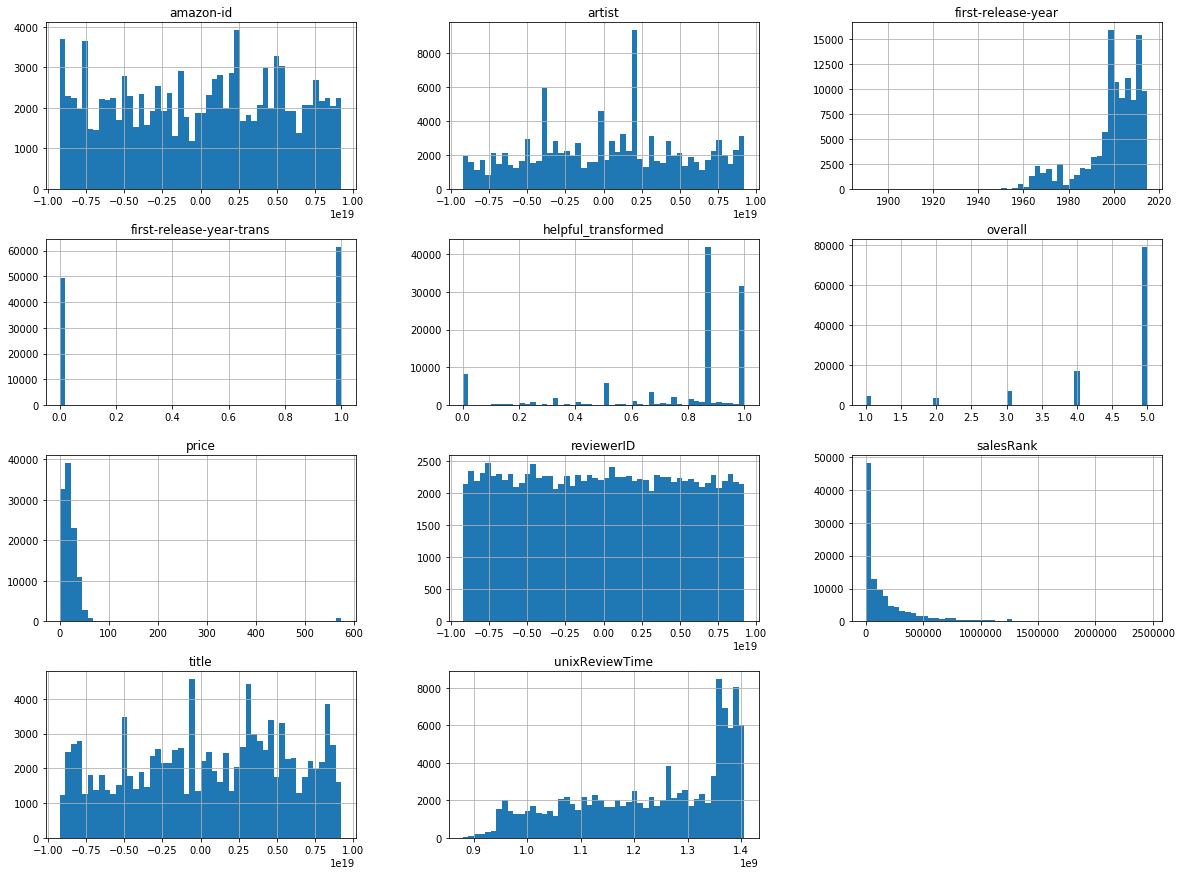

In [8]:
# histogram
df.hist(bins=50,figsize=(20,15))

In [9]:
# Pearson correlation for overall and other (entire)
corr_matrix = df.corr()
corr_matrix

,reviewerID,amazon-id,unixReviewTime,overall,price,title,artist,first-release-year,salesRank,helpful_transformed,first-release-year-trans
reviewerID,1.000000,0.002610,0.001351,0.003343,0.001911,0.000288,0.003953,0.011756,-0.005065,-0.002300,0.011223
amazon-id,0.002610,1.000000,0.074785,0.014093,0.025946,-0.067795,-0.037234,0.046232,0.004721,0.030059,0.074753
unixReviewTime,0.001351,0.074785,1.000000,0.049034,0.130343,-0.019658,-0.040846,0.257261,-0.161860,0.047542,0.278903
overall,0.003343,0.014093,0.049034,1.000000,-0.013251,0.009592,-0.026578,-0.018330,-0.014595,0.337780,-0.027163
price,0.001911,0.025946,0.130343,-0.013251,1.000000,-0.012641,0.029146,0.066358,-0.088962,-0.057042,-0.039339
title,0.000288,-0.067795,-0.019658,0.009592,-0.012641,1.000000,0.044103,-0.055900,-0.015224,-0.008270,-0.002068
artist,0.003953,-0.037234,-0.040846,-0.026578,0.029146,0.044103,1.000000,-0.016949,0.026994,-0.029459,-0.050580
first-release-year,0.011756,0.046232,0.257261,-0.018330,0.066358,-0.055900,-0.016949,1.000000,-0.150310,-0.008538,0.727767
salesRank,-0.005065,0.004721,-0.161860,-0.014595,-0.088962,-0.015224,0.026994,-0.150310,1.000000,0.039867,-0.180004
helpful_transformed,-0.002300,0.030059,0.047542,0.337780,-0.057042,-0.008270,-0.029459,-0.008538,0.039867,1.000000,-0.028390


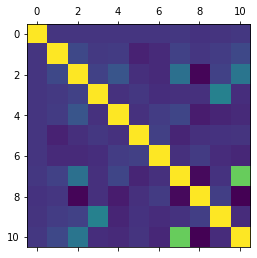

In [10]:
# regular correlation matrix by visualization
plt.matshow(corr_matrix)

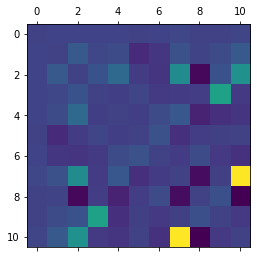

In [11]:
# by replacing diagonal values as 0, we visualized correlation matrix again to see the relationship. 
# it is noted that column 3 (overall rating) is a bit correlated to row 9 (helpful transformed)
corr_matrix_for_color = copy.deepcopy(corr_matrix.to_numpy())
np.fill_diagonal(corr_matrix_for_color, 0)
plt.matshow(corr_matrix_for_color)


## note:
# it seems that column 2 (unixReviewtime) is correlated to some feature like first realease year. 

In [12]:
corr_matrix['overall'].sort_values(ascending=False)

overall                     1.000000
helpful_transformed         0.337780
unixReviewTime              0.049034
amazon-id                   0.014093
title                       0.009592
reviewerID                  0.003343
price                      -0.013251
salesRank                  -0.014595
first-release-year         -0.018330
artist                     -0.026578
first-release-year-trans   -0.027163
Name: overall, dtype: float64

## Data pre-processing

### one hot encoding

In [13]:
# One hot encoding
# haven't done for processing with this in the algorithm yet
df['root-genre'] = df['root-genre'].astype('category')
root_genre_cat = df['root-genre']
root_genre_cat_encoded, root_genre_categories = root_genre_cat.factorize()
encoder = OneHotEncoder(categories='auto')
root_genre_cat_1hot = encoder.fit_transform(root_genre_cat_encoded.reshape(-1,1))
root_genre_cat_1hot.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
genre_dummies = pd.get_dummies(df['root-genre'])
df = df.join(genre_dummies)
df

,reviewerID,amazon-id,helpful,unixReviewTime,reviewText,overall,reviewTime,summary,price,categories,...,Gospel,Jazz,Latin Music,Metal,New Age,Pop,R&B,Rap & Hip-Hop,Reggae,Rock
0,-4984057859803657856,1877521326299865484,"[2, 2]",1302739200,Very nice music for practicing my Tai Chi. I d...,4,"04 14, 2011",Beautiful,16.47,"['CDs & Vinyl', 'New Age']",...,0,0,0,0,1,0,0,0,0,0
1,9136764282801708742,1877521326299865484,"[11, 11]",1180396800,I recently starting doing Tai Chi which I love...,5,"05 29, 2007",Tranquillity In Motion !!!,16.47,"['CDs & Vinyl', 'New Age']",...,0,0,0,0,1,0,0,0,0,0
2,2164551966908582519,1877521326299865484,"[0, 0]",1361404800,My wife uses it for her class room the kids lo...,5,"02 21, 2013",Great Stuff,16.47,"['CDs & Vinyl', 'New Age']",...,0,0,0,0,1,0,0,0,0,0
3,-7309200698931694843,1877521326299865484,"[4, 4]",1338163200,We bought this music to go Dr Lam DVD. The mus...,5,"05 28, 2012",Beautiful,16.47,"['CDs & Vinyl', 'New Age']",...,0,0,0,0,1,0,0,0,0,0
4,-4461682407031037732,1877521326299865484,"[0, 0]",1396310400,It helps me do my exercise because it sets the...,5,"04 1, 2014",tai chi music,16.47,"['CDs & Vinyl', 'New Age']",...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111093,-508419005999372045,-272019625357917459,"[0, 0]",1405900800,Nice soundtrack and I was pleasantly surprised...,4,"07 21, 2014",Four Stars,33.76,"['CDs & Vinyl', 'Pop']",...,0,0,0,0,0,1,0,0,0,0
111094,4690686471314282919,-272019625357917459,"[12, 13]",1405209600,I'd you are looking for the music that they sa...,5,"07 13, 2014",I'd you are looking for the music that they sa...,33.76,"['CDs & Vinyl', 'Pop']",...,0,0,0,0,0,1,0,0,0,0
111095,-6735807132142826990,-272019625357917459,"[3, 4]",1404259200,FANTASTIC FILM! Loved this movie and the musi...,5,"07 2, 2014",FANTASTIC FILM! Loved this movie and the music,33.76,"['CDs & Vinyl', 'Pop']",...,0,0,0,0,0,1,0,0,0,0
111096,6536263939078780437,2197509461459270640,"[0, 0]",1404518400,"A great new CD with uptempo, funky guitar. Thi...",5,"07 5, 2014",A great new CD with uptempo,32.98,"['CDs & Vinyl', 'Jazz', 'Smooth Jazz']",...,0,1,0,0,0,0,0,0,0,0


### Make relevant feature

In [15]:
# add total_song length feature
df['total_songs'] = df['songs'].apply(lambda x: len(x))
df['total_copurchase'] = df['related'].apply(lambda x: len(x))

In [16]:
df.head(2)

,reviewerID,amazon-id,helpful,unixReviewTime,reviewText,overall,reviewTime,summary,price,categories,...,Latin Music,Metal,New Age,Pop,R&B,Rap & Hip-Hop,Reggae,Rock,total_songs,total_copurchase
0,-4984057859803657856,1877521326299865484,"[2, 2]",1302739200,Very nice music for practicing my Tai Chi. I d...,4,"04 14, 2011",Beautiful,16.47,"['CDs & Vinyl', 'New Age']",...,0,0,1,0,0,0,0,0,213,1687
1,9136764282801708742,1877521326299865484,"[11, 11]",1180396800,I recently starting doing Tai Chi which I love...,5,"05 29, 2007",Tranquillity In Motion !!!,16.47,"['CDs & Vinyl', 'New Age']",...,0,0,1,0,0,0,0,0,213,1687


### drop NaN data

In [17]:
# drop both
#df_clean = df.dropna(subset=["helpful_transformed", "first-release-year"])

# Update 2021.02.02
# without dropping NaN of first release year
# Note: helpful transformed is filled with value 0.5 above
df_clean = df
df_clean.describe()

,reviewerID,amazon-id,unixReviewTime,overall,price,title,artist,first-release-year,salesRank,helpful_transformed,...,Latin Music,Metal,New Age,Pop,R&B,Rap & Hip-Hop,Reggae,Rock,total_songs,total_copurchase
count,1.110980e+05,1.110980e+05,1.110980e+05,111098.000000,111098.000000,1.110980e+05,1.110980e+05,111098.000000,1.110980e+05,111098.000000,...,111098.000000,111098.000000,111098.000000,111098.000000,111098.000000,111098.000000,111098.000000,111098.000000,111098.000000,111098.000000
mean,-6.818128e+16,-2.084993e+16,1.232084e+09,4.470107,25.445660,4.769060e+17,3.154712e+17,1999.511700,2.105844e+05,0.769011,...,0.061810,0.020324,0.024240,0.425867,0.015383,0.021810,0.002700,0.196889,302.522908,1523.974239
std,5.322657e+18,5.406624e+18,1.414562e+08,1.018322,52.937804,5.215440e+18,4.947027e+18,12.810333,3.559923e+05,0.292351,...,0.240812,0.141108,0.153794,0.494476,0.123070,0.146062,0.051895,0.397650,116.463857,888.042236
min,-9.223209e+18,-9.217724e+18,8.794656e+08,1.000000,0.010000,-9.221116e+18,-9.223268e+18,1890.000000,6.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,36.000000
25%,-4.678906e+18,-4.828751e+18,1.117584e+09,4.000000,10.170000,-3.788099e+18,-3.758738e+18,1996.000000,6.523000e+03,0.714286,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,235.000000,551.000000
50%,-8.388757e+16,3.880940e+17,1.262995e+09,5.000000,16.990000,6.582631e+17,7.017061e+17,2002.000000,7.566650e+04,0.875000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,278.000000,2192.000000
75%,4.521390e+18,4.723283e+18,1.362355e+09,5.000000,28.360000,4.666139e+18,4.215883e+18,2009.000000,2.480288e+05,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,364.000000,2313.000000
max,9.222415e+18,9.222653e+18,1.406074e+09,5.000000,575.170000,9.222522e+18,9.222169e+18,2015.000000,2.453642e+06,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,550.000000,2346.000000


In [18]:
df_clean.head(3)

,reviewerID,amazon-id,helpful,unixReviewTime,reviewText,overall,reviewTime,summary,price,categories,...,Latin Music,Metal,New Age,Pop,R&B,Rap & Hip-Hop,Reggae,Rock,total_songs,total_copurchase
0,-4984057859803657856,1877521326299865484,"[2, 2]",1302739200,Very nice music for practicing my Tai Chi. I d...,4,"04 14, 2011",Beautiful,16.47,"['CDs & Vinyl', 'New Age']",...,0,0,1,0,0,0,0,0,213,1687
1,9136764282801708742,1877521326299865484,"[11, 11]",1180396800,I recently starting doing Tai Chi which I love...,5,"05 29, 2007",Tranquillity In Motion !!!,16.47,"['CDs & Vinyl', 'New Age']",...,0,0,1,0,0,0,0,0,213,1687
2,2164551966908582519,1877521326299865484,"[0, 0]",1361404800,My wife uses it for her class room the kids lo...,5,"02 21, 2013",Great Stuff,16.47,"['CDs & Vinyl', 'New Age']",...,0,0,1,0,0,0,0,0,213,1687


In [19]:
# Todo 
# 1. drop na or imputation for na by median for each id ==> fillna
# 2. normalization of quantitative values
# 3. Hyperparameter change grid search
# 4. Cross validation
# 5. Weighted F1
# 6. Confusion matrix for error checking and what classes have been found to be identified
# 7. Other feature like album how many songs? category?
# 8. first release year NaN ==> map by the earliest review year
# 9. Helpful review NaN ==> fill 
# 10. pipeline
# 11. correlation for aggregated one

In [20]:
df['root-genre'].value_counts()

Pop                   47313
Rock                  21874
Classical              6879
Latin Music            6867
Country                4454
Jazz                   4021
Dance & Electronic     4020
Alternative Rock       2797
New Age                2693
Rap & Hip-Hop          2423
Folk                   2260
Metal                  2258
R&B                    1709
Blues                   630
Gospel                  600
Reggae                  300
Name: root-genre, dtype: int64

### Text and Unnecessary Data Drop

In [21]:
df_clean.drop(['helpful', 'reviewText', 'summary', 'categories', 'root-genre', 'label', 'reviewTime'], axis=1)

# only using data for quant analysis
# with first-release-year
feature_names = ["amazon-id", "unixReviewTime", "price", "first-release-year", "first-release-year-trans", "salesRank", "helpful_transformed", "total_songs", "total_copurchase",  "overall"]

genre_encoded_feature = [
"Pop",
"Rock",
"Classical",
 "Latin Music",            
"Country",
 "Jazz",
"Dance & Electronic",
"Alternative Rock",
"New Age",
"Rap & Hip-Hop",
"Folk",
"Metal",
"R&B",
"Blues",
"Gospel",
"Reggae"]
feature_names = feature_names + genre_encoded_feature

# candidate later: "songs", "related", "title", "reviewerID", "amazon-id", 

quant_data = df_clean[feature_names]
#predicted_variable = df_clean['predict_target']

quant_data.head()

,amazon-id,unixReviewTime,price,first-release-year,first-release-year-trans,salesRank,helpful_transformed,total_songs,total_copurchase,overall,...,Dance & Electronic,Alternative Rock,New Age,Rap & Hip-Hop,Folk,Metal,R&B,Blues,Gospel,Reggae
0,1877521326299865484,1302739200,16.47,1999.5117,0,27222,1.000,213,1687,4,...,0,0,1,0,0,0,0,0,0,0
1,1877521326299865484,1180396800,16.47,1999.5117,0,27222,1.000,213,1687,5,...,0,0,1,0,0,0,0,0,0,0
2,1877521326299865484,1361404800,16.47,1999.5117,0,27222,0.875,213,1687,5,...,0,0,1,0,0,0,0,0,0,0
3,1877521326299865484,1338163200,16.47,1999.5117,0,27222,1.000,213,1687,5,...,0,0,1,0,0,0,0,0,0,0
4,1877521326299865484,1396310400,16.47,1999.5117,0,27222,0.875,213,1687,5,...,0,0,1,0,0,0,0,0,0,0


### Aggregation

In [22]:
"""
product_data = quant_data.groupby('amazon-id').agg({
    'unixReviewTime': 'mean',
    'price': 'mean',
    'first-release-year': 'mean',
    'overall': 'mean',
    'salesRank': 'mean',
    'helpful_transformed': 'mean',
    'total_songs': 'mean',
    'total_copurchase': 'mean'
    })
"""
product_data = quant_data.groupby('amazon-id').agg({
    'unixReviewTime': 'mean',
    'price': 'mean',
    'first-release-year': 'mean',
    'first-release-year-trans': 'mean',
    'overall': 'mean',
    'salesRank': 'mean',
    'helpful_transformed': 'mean',
    'total_songs': 'mean',
    'total_copurchase': 'mean',
    "Pop": 'sum',
    "Rock": 'sum',
    "Classical": 'sum',
     "Latin Music": 'sum',           
    "Country": 'sum',
     "Jazz": 'sum',
    "Dance & Electronic": 'sum',
    "Alternative Rock": 'sum',
    "New Age": 'sum',
    "Rap & Hip-Hop": 'sum',
    "Folk": 'sum',
    "Metal": 'sum',
    "R&B": 'sum',
    "Blues": 'sum',
    "Gospel": 'sum',
    "Reggae": 'sum'
    })

product_data['Target'] = np.where(product_data['overall'] >= 4.5, True, False)
product_data

,unixReviewTime,price,first-release-year,first-release-year-trans,overall,salesRank,helpful_transformed,total_songs,total_copurchase,Pop,...,Alternative Rock,New Age,Rap & Hip-Hop,Folk,Metal,R&B,Blues,Gospel,Reggae,Target
amazon-id,,,,,,,,,,,,,,,,,,,,,
-9217723718720870868,1.102771e+09,9.90,1981.0000,0,4.333333,1310516,0.620370,278,2277,0.0,...,0.0,0.0,0.0,0.0,0.0,9.0,0,0,0,False
-9215746463819797371,1.285416e+09,48.11,2009.0000,1,5.000000,309139,0.937500,237,210,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0,0,0,True
-9213978596308513604,1.245283e+09,15.86,1978.0000,0,3.000000,280309,0.666667,192,422,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,False
-9211290576571923870,1.094861e+09,17.37,1993.0000,0,4.500000,321654,1.000000,536,187,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,True
-9208769561690910545,1.042340e+09,12.00,2002.0000,1,4.500000,17515,0.812500,517,317,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9218870320655141661,1.219061e+09,8.99,2006.0000,1,3.500000,1760050,0.500000,213,252,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0,0,0,False
9221578337502519209,1.338098e+09,13.43,2010.0000,1,4.875000,149220,0.921875,297,802,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,True
9221615570697142155,1.241654e+09,14.18,1999.5117,0,5.000000,600235,1.000000,234,80,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0,0,0,True


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020E1D1187B8>,
      dtype=object)

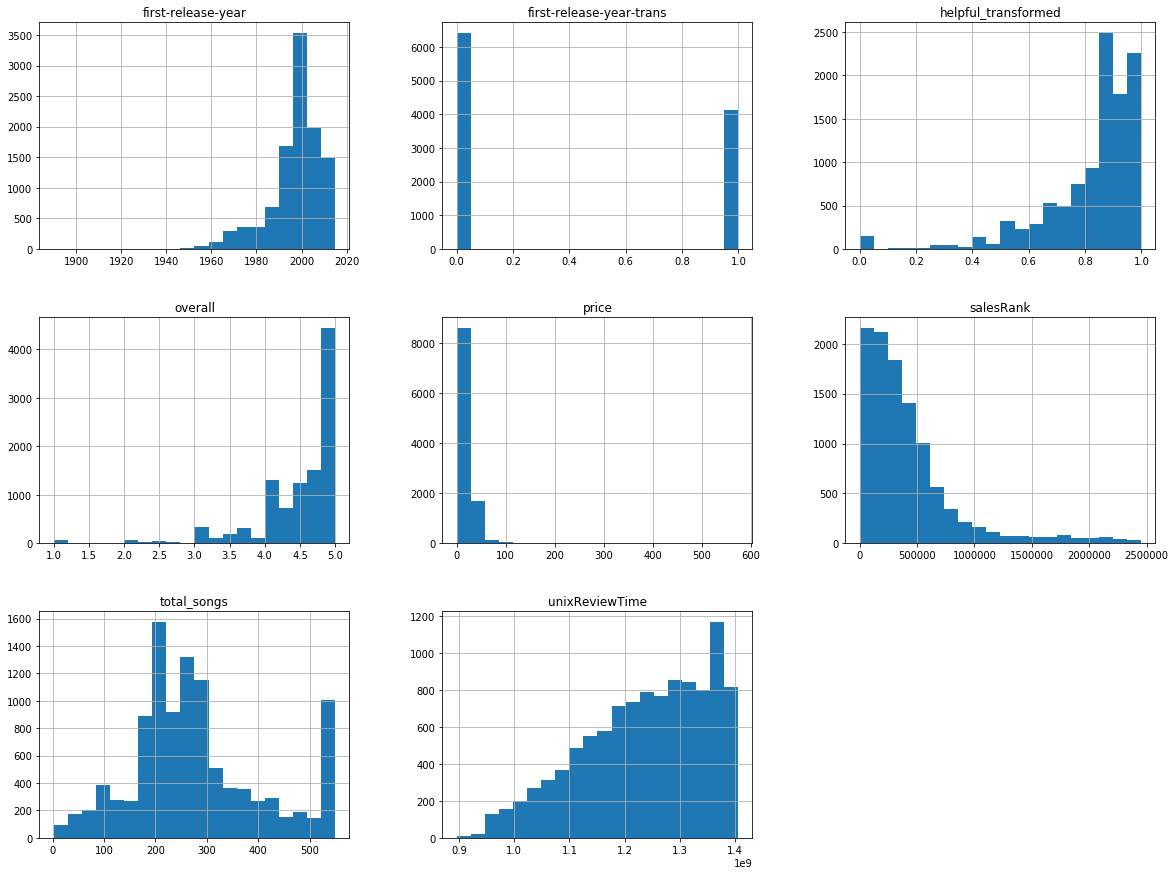

In [23]:
product_data.iloc[:, :8].hist(bins=20,figsize=(20,15))

In [24]:
# normalization
# warning message no problem. ignore
for col in product_data.columns[:-1]: 
    product_data[col] = normalize_column_data(product_data[col])

In [25]:
product_data

,unixReviewTime,price,first-release-year,first-release-year-trans,overall,salesRank,helpful_transformed,total_songs,total_copurchase,Pop,...,Alternative Rock,New Age,Rap & Hip-Hop,Folk,Metal,R&B,Blues,Gospel,Reggae,Target
amazon-id,,,,,,,,,,,,,,,,,,,,,
-9217723718720870868,0.405889,0.017195,0.728000,0.0,0.833333,0.534109,0.620370,0.503650,0.970130,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.027864,0.0,0.0,0.0,False
-9215746463819797371,0.764063,0.083629,0.952000,1.0,1.000000,0.125990,0.937500,0.428832,0.075325,0.000000,...,0.0,0.008621,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,True
-9213978596308513604,0.685361,0.027558,0.704000,0.0,0.500000,0.114240,0.666667,0.346715,0.167100,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,False
-9211290576571923870,0.390376,0.030183,0.824000,0.0,0.875000,0.131090,1.000000,0.974453,0.065368,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,True
-9208769561690910545,0.287381,0.020846,0.896000,1.0,0.875000,0.007136,0.812500,0.939781,0.121645,0.008316,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9218870320655141661,0.633938,0.015613,0.928000,1.0,0.625000,0.717321,0.500000,0.385036,0.093506,0.000000,...,0.0,0.000000,0.0,0.0,0.006689,0.000000,0.0,0.0,0.0,False
9221578337502519209,0.867375,0.023333,0.960000,1.0,0.968750,0.060813,0.921875,0.538321,0.331602,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,True
9221615570697142155,0.678245,0.024637,0.876094,0.0,1.000000,0.244628,1.000000,0.423358,0.019048,0.000000,...,0.0,0.004310,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,True


## Train and Test Models

### Define classifiers

In [26]:
# Classifiers
# GNB
gnb_clf = sklearn.naive_bayes.GaussianNB()
# Decision Tree
tree_clf = sklearn.tree.DecisionTreeClassifier(max_depth=4)

# Random Forest
RF_clf = RandomForestClassifier(n_estimators=300, max_leaf_nodes=16, n_jobs=-1)

# Logistic regression
LR_clf = sklearn.linear_model.LogisticRegression(max_iter=100000, class_weight='balanced')

# SVM linear
svm_clf = SVC(kernel="linear", C=1)
# SVM poly
svm_poly_clf = SVC(kernel='poly', degree=2)
# SVM rbf
svm_rbf_clf = SVC(kernel='rbf')
# SVM sigmoid
svm_sig_clf = SVC(kernel='sigmoid')

# index j below cell iteration
classifiers = [gnb_clf, tree_clf, RF_clf, LR_clf, svm_clf, svm_poly_clf, svm_rbf_clf, svm_sig_clf]
name = ["Gaussian Naive", "Decision Tree", "Random Forest", "Logistic regression", "Support Vector Machine - linear",
        "Support Vector Machine - poly", "Support Vector Machine - RDF", "Support Vector Machine - Sigmoid"]

### Data split by Kfold and performance save
* Watch out! it takes long time

In [27]:
# variable divide for training
# ====================================
# 1. feature extraction
# with first-release-year
training_feature_list = list()

training_feature_0 = ["unixReviewTime", "price", "first-release-year", "salesRank", "helpful_transformed", "total_songs", "total_copurchase"]
training_feature_1 = ["unixReviewTime", "price", "salesRank", "helpful_transformed", "total_songs", "total_copurchase"]
training_feature_2 = ["unixReviewTime", "price", "salesRank", "helpful_transformed", "total_copurchase"]
training_feature_3 = ["unixReviewTime", "price", "salesRank", "helpful_transformed", "total_songs"]
training_feature_4 = ["unixReviewTime", "price", "salesRank", "helpful_transformed"]
training_feature_5 = ["price", "salesRank", "helpful_transformed"]
training_feature_6 = ["salesRank", "helpful_transformed"]
training_feature_7 = ["helpful_transformed"]
training_feature_8 = ["helpful_transformed", "first-release-year-trans"]
training_feature_9 = training_feature_0 + ["Pop", "Rock","Classical", "Latin Music","Country", "Jazz","Dance & Electronic",
"Alternative Rock","New Age","Rap & Hip-Hop","Folk","Metal","R&B","Blues","Gospel","Reggae"]

# index i for iteration
#training_feature_list = [training_feature_0, training_feature_1, training_feature_2, training_feature_3, training_feature_4, training_feature_5,
#                         training_feature_6, training_feature_7, training_feature_8]
# for short time just checking 
#training_feature_list = [training_feature_0, training_feature_1]
training_feature_list = [training_feature_7, training_feature_8]

# fixed 
result_feature = ['Target']
dependent_variable = product_data[result_feature]
f1_performance_comparison_dict = dict()
acc_performance_comparison_dict = dict()
runtime_performance_comparison_dict = dict()
# ====================================

In [28]:
for i, training_feature in enumerate(training_feature_list):
    independent_variable = product_data[training_feature]
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
    print("==================================================================")
    print("training features used number {},\n list: {}".format(i, training_feature))
    for j, model in enumerate(classifiers):
        start_time = timer()
        cv_results_acc = model_selection.cross_val_score(model, independent_variable, dependent_variable.values.ravel(), cv=kfold, scoring='accuracy')
        cv_results_f1 = model_selection.cross_val_score(model, independent_variable, dependent_variable.values.ravel(), cv=kfold, scoring='f1_weighted')
        end_time = timer()
        print("------------------------------------------------------------------")
        print("model name: {}".format(name[j]))
        print("f1_weighted score list: {}".format(cv_results_f1))
        print("f1_weighted score average: {}".format(np.mean(cv_results_f1)))  
        print("accuracy score list: {}".format(cv_results_acc))
        print("accuracy score average: {}".format(np.mean(cv_results_acc)))
        print("running time (sec): {}".format(end_time - start_time))
        
        f1_performance_comparison_dict[(i,j)] = np.mean(cv_results_f1)
        acc_performance_comparison_dict[(i,j)] = np.mean(cv_results_acc)
        runtime_performance_comparison_dict[(i,j)] = end_time - start_time
        #print(confusion_matrix(y_test,y_pred))
        #print(classification_report(y_test,y_pred))

training features used number 0,
 list: ['helpful_transformed']
------------------------------------------------------------------
model name: Gaussian Naive
f1_weighted score list: [0.59022534 0.60099701 0.59972052 0.60282229 0.57125833]
f1_weighted score average: 0.5930046982530243
accuracy score list: [0.65860597 0.66761498 0.66571835 0.67125237 0.65085389]
accuracy score average: 0.6628091139176728
running time (sec): 0.03875889999999771
------------------------------------------------------------------
model name: Decision Tree
f1_weighted score list: [0.66007419 0.67259516 0.66497707 0.65587257 0.64931185]
f1_weighted score average: 0.6605661682985977
accuracy score list: [0.68610716 0.69843528 0.68895211 0.67931689 0.67741935]
accuracy score average: 0.6860461580126016
running time (sec): 0.06261779999999817
------------------------------------------------------------------
model name: Random Forest
f1_weighted score list: [0.6512982  0.67337959 0.65950428 0.65152683 0.64359814]

### Max performance finder

In [29]:
# finding the maximum performance
# weighted f1 score best
f1_best_key = max(f1_performance_comparison_dict, key=f1_performance_comparison_dict.get)
print("*******************************************************************")
print("final selected model for weighted F1: {} with value: {}".format(name[f1_best_key[1]], f1_performance_comparison_dict[f1_best_key]))
print("when using the number: {} with features: \n {}".format(f1_best_key[0], training_feature_list[f1_best_key[0]]))

# accuracy best
acc_best_key = max(acc_performance_comparison_dict, key=acc_performance_comparison_dict.get)
print("*******************************************************************")
print("final selected model for weighted accuracy: {} with value: {}".format(name[acc_best_key[1]], acc_performance_comparison_dict[acc_best_key]))
print("when using the features: {} with features: \n {}".format(acc_best_key[0], training_feature_list[acc_best_key[0]]))

# runtime best
run_best_key = min(runtime_performance_comparison_dict, key=runtime_performance_comparison_dict.get)
print("*******************************************************************")
print("final selected model for runtime: {} with value: {}".format(name[run_best_key[1]], runtime_performance_comparison_dict[run_best_key]))
print("when using the features: {} with features: \n {}".format(run_best_key[0], training_feature_list[run_best_key[0]]))

*******************************************************************
final selected model for weighted F1: Logistic regression with value: 0.665052119757708
when using the number: 0 with features: 
 ['helpful_transformed']
*******************************************************************
final selected model for weighted accuracy: Random Forest with value: 0.6882279163213948
when using the features: 0 with features: 
 ['helpful_transformed']
*******************************************************************
final selected model for runtime: Gaussian Naive with value: 0.03875889999999771
when using the features: 0 with features: 
 ['helpful_transformed']


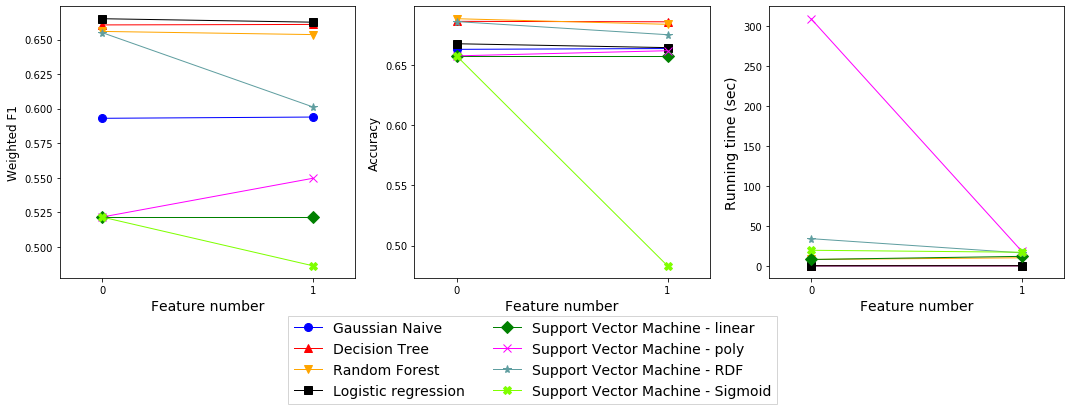

In [30]:
fig = plt.figure(figsize=(18,5))
ax1 = plt.subplot2grid((1, 3), (0, 0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((1, 3), (0, 1), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((1, 3), (0, 2), rowspan=1, colspan=1)
ax = [ax1, ax2, ax3]
x_limit = [-0.2, len(training_feature_list)-0.8]

ax1.set_ylabel('Weighted F1', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax3.set_ylabel('Running time (sec)', fontsize=14)

for each in ax:
    each.set_aspect('auto')
    each.set_xlim(x_limit[0], x_limit[1])
    each.set_xticks(np.arange(0,x_limit[1],1))    
    each.set_xlabel('Feature number', fontsize=14)

color_map =['blue',
'red',
'orange',
'black',
'green',
'magenta',
'cadetblue',
'chartreuse',
'chocolate',
'coral',
'cornflowerblue',      
'deepskyblue',         
'limegreen']
marker_list = ['o', '^', 'v', 's', 'D' , 'x', '*', 'X']

for model_index in range(len(classifiers)):
    feature_type = []
    model_f1_preformance = []
    model_acc_preformance = []
    model_time_performance = []
    for key, val in f1_performance_comparison_dict.items():
        if int(key[1]) == int(model_index):
            feature_type.append(key[0])
            model_f1_preformance.append(val)
            model_acc_preformance.append(acc_performance_comparison_dict[key])
            model_time_performance.append(runtime_performance_comparison_dict[key])
    ax1.plot(feature_type, model_f1_preformance, lw=1, marker=marker_list[model_index], markersize=8, color=color_map[model_index], label=name[model_index])
    ax2.plot(feature_type, model_acc_preformance, lw=1, marker=marker_list[model_index], markersize=8, color=color_map[model_index], label=name[model_index])
    ax3.plot(feature_type, model_time_performance, lw=1, marker=marker_list[model_index], markersize=8, color=color_map[model_index], label=name[model_index])

plt.legend(loc='center', bbox_to_anchor=(-0.8, -0.3), fancybox=False, shadow=False, ncol=2, fontsize=14)
plt.savefig('performance.png')
plt.show()

### Desition Tree example when best result 

In [31]:
# train and test data split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(product_data[training_feature_7], dependent_variable, test_size=0.3, shuffle=True)

In [32]:
# Decision tree
print("Trying a decision tree")
tree_clf = sklearn.tree.DecisionTreeClassifier(max_depth=4)
tree_clf.fit(X_train, y_train)
y_pred = tree_clf.predict(X_test)
print("F1 score: {}".format(sklearn.metrics.f1_score(y_test, y_pred, average='weighted')))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
print("accuracy score: {}".format(sklearn.metrics.accuracy_score(y_test, y_pred)))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Trying a decision tree
F1 score: 0.6558065366136568
accuracy score: 0.6841606070186532
[[ 345  738]
 [ 261 1819]]
              precision    recall  f1-score   support

       False       0.57      0.32      0.41      1083
        True       0.71      0.87      0.78      2080

    accuracy                           0.68      3163
   macro avg       0.64      0.60      0.60      3163
weighted avg       0.66      0.68      0.66      3163

